In [694]:
import torch
from IPython import display
from d2l import torch as d2l
import pandas as pd
import numpy as np
from pandas import DataFrame,Series


In [695]:
#读取训练数据集 和  测试数据集
all_feature = pd.read_csv("../data/sample.csv")
all_test = pd.read_csv("../data/test.csv")
# 先是pands类型的数据 进行数据切片 分为 数据和label  
# feature 是 float32  label 是长整型
feature = all_feature.iloc[:,0:-1].astype(np.float32)
label = all_feature.iloc[:,-1].astype(np.long)

test_feature = all_test.iloc[:,0:-1].astype(np.float32)
test_label = all_test.iloc[:,-1].astype(np.long)

In [696]:
# 把 俩个变量 feature 和 label 做成 list 
class GetLoader(torch.utils.data.Dataset):
	# 初始化函数，得到数据
    def __init__(self, data_root, data_label):
        self.data = data_root
        self.label = data_label
    # index是根据batchsize划分数据后得到的索引，最后将data和对应的labels进行一起返回
    def __getitem__(self, index):
        data = self.data[index]
        labels = self.label[index]
        return data, labels
    # 该函数返回数据大小长度，目的是DataLoader方便划分，如果不知道大小，DataLoader会一脸懵逼
    def __len__(self):
        return len(self.data)

In [697]:
# 再把np array 类型的数据转化为tensor 类型
feature = torch.tensor(feature.values)
label = torch.tensor(label.values).type(torch.long)

test_feature = torch.tensor(test_feature.values)
test_label = torch.tensor(test_label.values).type(torch.long)

In [698]:
feature

tensor([[0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
        [0.0300, 0.0200, 0.0300,  ..., 0.0200, 0.0300, 0.0300],
        [0.0300, 0.0300, 0.0300,  ..., 0.0300, 0.0300, 0.0300],
        ...,
        [0.0400, 0.0400, 0.0400,  ..., 0.0400, 0.0400, 0.0400],
        [0.0600, 0.0600, 0.0600,  ..., 0.0600, 0.0600, 0.0600],
        [0.0300, 0.0300, 0.0200,  ..., 0.0300, 0.0300, 0.0200]])

In [699]:
feature = torch.nn.init.xavier_uniform_(feature)
test_feature = torch.nn.init.xavier_uniform_(test_feature)

In [700]:
#生成训练集和测试集
dataset = GetLoader(feature,label)

test_dataset = GetLoader(test_feature,test_label)

In [701]:
from torch import nn

In [702]:
num_inputs, num_outputs, num_hiddens = 70, 3, 70

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

In [703]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [704]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [705]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [706]:
dropout1 = 0.3
def net(X):
    X = X.reshape((-1, num_inputs))
    H = relu(X@W1 + b1)  # 这里“@”代表矩阵乘法
    H = dropout_layer(H, dropout1)
    return softmax(H@W2 + b2)

In [707]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

In [708]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [709]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式  
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [710]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [711]:
#这里的权重和偏置是怎么更新的
# def updater(batch_size):
#     return d2l.sgd([W1,b1,W2,b2], lr, batch_size)
lr =0.15
updater = torch.optim.SGD(params, lr=lr,weight_decay=0)

In [712]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
#         print(y_hat)
        l = loss(y_hat, y)
#         print(y)
#         print(l)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [713]:
train_epoch_ch3(net,dataset,cross_entropy,updater)

(1.1271906561255456, 0.306)

In [714]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [715]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 1.5],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

AssertionError: 0.9929152486140083

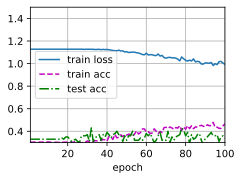

In [716]:

batch_size = 50
num_epochs = 100
train_ch3(net, dataset, test_dataset, cross_entropy, num_epochs, updater)

In [ ]:
evaluate_accuracy(net,dataset)

In [ ]:
evaluate_accuracy(net,test_dataset)